# East coast floods


In [1]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils
from unseen import indices

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [7]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/hydrotas/data/Rx14day_AGCD-CSIRO_r005_1900-2022_annual_hydro-tas.zarr.zip"
model_file = "/g/data/xv83/dbi599/hydrotas/data/Rx14day_CAFE-c5-d60-pX-f6_19950501-20201101_annual_hydro-tas.zarr.zip"
model_add_bc_file = "/g/data/xv83/dbi599/hydrotas/data/Rx14day_CAFE-c5-d60-pX-f6_19950501-20201101_annual_hydro-tas_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
model_mulc_bc_file = "/g/data/xv83/dbi599/hydrotas/data/Rx14day_CAFE-c5-d60-pX-f6_19950501-20201101_annual_hydro-tas_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_add_bc_file = "/g/data/xv83/dbi599/hydrotas/data/similarity-test_Rx14day_CAFE-c5-d60-pX-f6_1995-2020_annual_hydro-tas_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
similarity_mulc_bc_file = "/g/data/xv83/dbi599/hydrotas/data/similarity-test_Rx14day_CAFE-c5-d60-pX-f6_1995-2020_annual_hydro-tas_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/hydrotas/data/similarity-test_Rx14day_CAFE-c5-d60-pX-f6_1995-2020_annual_hydro-tas_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/hydrotas/figures/independence-test_Rx14day_CAFE-c5-d60-pX-f6_19950501-20201101_annual_hydro-tas.png"
model_name = "CAFE"
min_lead = 3
region_name = "hydro-tas"
shape_file = "/home/599/dbi599/hydrotas/shapefiles/hydro-combined.shp"
file_list = "/home/599/dbi599/hydrotas/file_lists/CAFE_c5-d60-pX-f6_pr_files.txt"
nino_file = "/g/data/xv83/dbi599/hydrotas/data/nino34-anomaly_CAFE-c5-d60-pX-f6_19950501-20201101_base-1995-2020.nc"


In [8]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p model_file [filepath])"
assert os.path.isfile(model_add_bc_file), "Must provide a model additive bias corrected data file (papermill option -p model_add_bc_file [filepath])"
assert os.path.isfile(model_mulc_bc_file), "Must provide a model multiplicative bias corrected data file (papermill option -p model_mulc_bc_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a model Nino 3.4 data file (papermill option -p nino_file [filepath])"
assert os.path.isfile(similarity_add_bc_file), "Must provide an additive bias corrected similarity test file (papermill option -p similarity_add_bias_file [filepath])"
assert os.path.isfile(similarity_mulc_bc_file), "Must provide an multiplicative bias corrected similarity test file (papermill option -p similarity_mulc_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [9]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [10]:
agcd_ds

<xarray.Dataset>
Dimensions:     (time: 122)
Coordinates:
    event_time  (time) <U28 dask.array<chunksize=(122,), meta=np.ndarray>
  * time        (time) object 1901-01-01 09:00:00 ... 2022-01-01 09:00:00
Data variables:
    pr          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [11]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [12]:
prmax = agcd_ds['pr'].values.max()
print(prmax)

277.08005


## Model ensemble

### Region selection

In [13]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [14]:
first_file

'/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19950501/atmos_isobaric_daily.zarr.zip'

In [15]:
shapes = gp.read_file(shape_file)

In [16]:
isel_dict = {}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [17]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    lat_bnds=[-47, -37],
    lon_bnds=[141, 152],
    shapefile=shape_file,
    shape_overlap=0.05,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

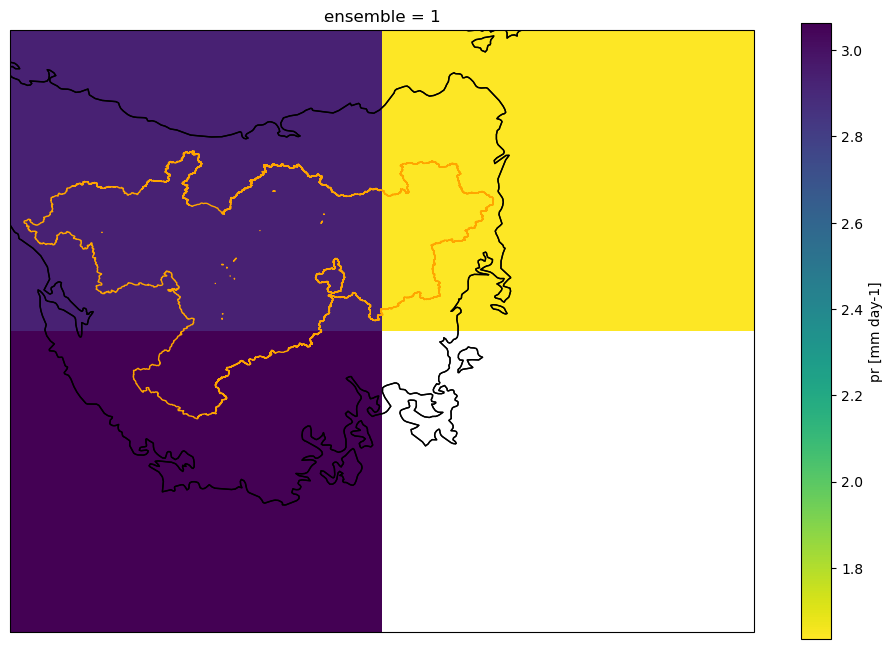

In [18]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].mean('time', keep_attrs=True).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [19]:
model_ds = fileio.open_dataset(model_file)
model_add_bc_ds = fileio.open_dataset(model_add_bc_file)
model_mulc_bc_ds = fileio.open_dataset(model_mulc_bc_file)

In [20]:
model_ds

<xarray.Dataset>
Dimensions:     (ensemble: 96, init_date: 52, lead_time: 11)
Coordinates:
  * ensemble    (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
    event_time  (init_date, lead_time, ensemble) <U28 dask.array<chunksize=(52, 11, 96), meta=np.ndarray>
  * init_date   (init_date) object 1995-05-01 00:00:00 ... 2020-11-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time        (lead_time, init_date) object dask.array<chunksize=(11, 52), meta=np.ndarray>
Data variables:
    pr          (init_date, lead_time, ensemble) float64 dask.array<chunksize=(1, 11, 96), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    history:    Wed Apr 05 12:31:49 2023: /g/data/xv83/dbi599/miniconda3/envs...
    title:      AccessOcean-AM2

### Independence testing

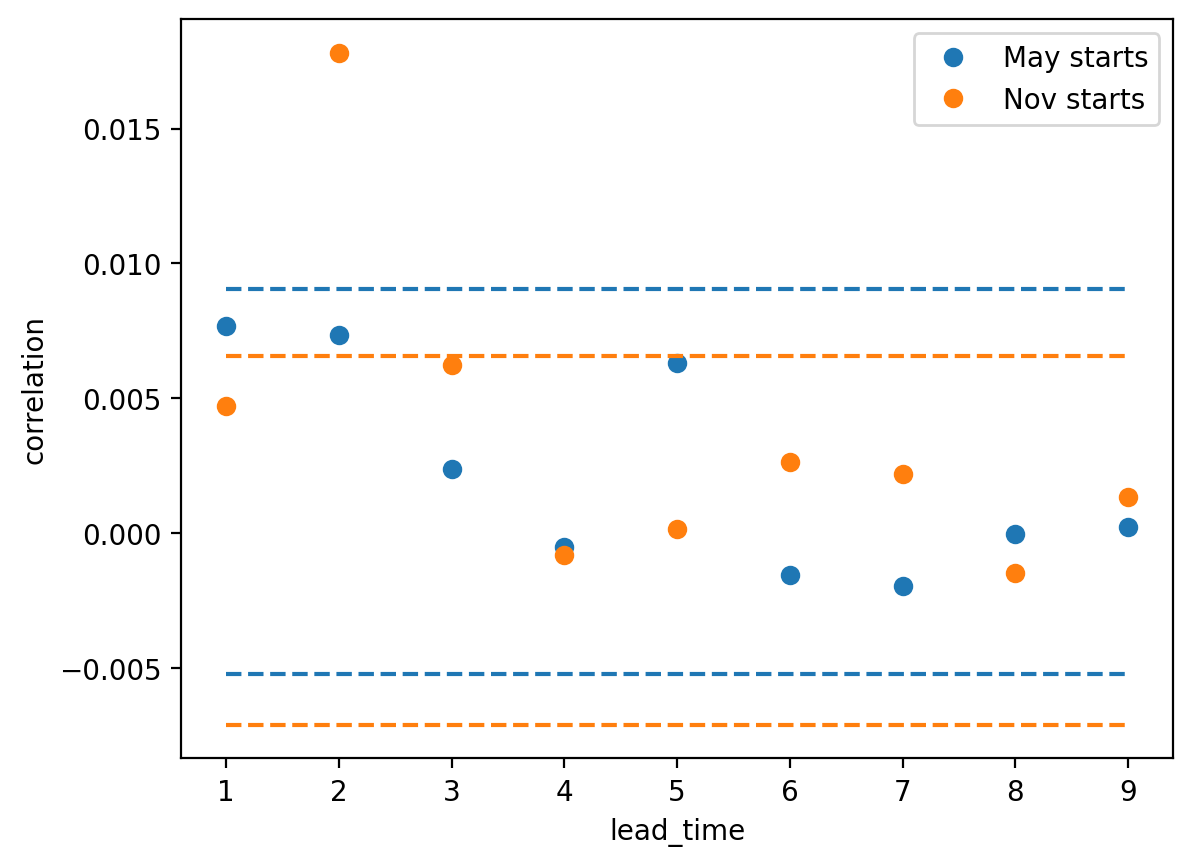

In [21]:
Image(filename=independence_plot)

In [ ]:
print(min_lead)

In [ ]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

In [ ]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [ ]:
model_da_stacked.shape

In [ ]:
model_add_bc_da_stacked = model_add_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [ ]:
model_add_bc_da_stacked.shape

In [ ]:
model_mulc_bc_da_stacked = model_mulc_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [ ]:
model_mulc_bc_da_stacked.shape

### Stability testing

In [ ]:
def plot_dist_by_lead(sample_ds, model_name):
    """Plot distribution curve by lead time"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    lead_times = np.unique(model_da_stacked['lead_time'].values)
    colors = iter(plt.cm.BuPu(np.linspace(0.3, 1, len(lead_times))))

    for lead in lead_times:
        ds_selection = sample_ds.sel({'lead_time': lead})
        ds_selection = ds_selection.dropna('sample')
        color = next(colors)
        lead_df = pd.DataFrame(ds_selection.values)
        n_values = len(ds_selection)
        sns.kdeplot(lead_df[0], ax=ax, color=color, label=f'lead time {lead} ({n_values} samples)')

    ax.grid(True)
    #ax.set_xlim(26, 46)    
    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.legend()
    plt.show()

In [ ]:
plot_dist_by_lead(model_da_stacked, model_name)

In [ ]:
def return_curve(data, method):
    """Return x and y data for a return period curve.
    
    Args:
      data: xarray DataArray
      method : {'gev', 'empirical'}
          Fit a GEV or not to data
    """
    
    if method == 'gev':
        return_periods = np.logspace(0, 4, num=10000)
        probabilities = 1. / return_periods
        shape, loc, scale = indices.fit_gev(data, generate_estimates=True)
        return_values = gev.isf(probabilities, shape, loc, scale)
    elif method == 'empirical':
        return_values = np.sort(data, axis=None)[::-1]
        return_periods = len(data) / np.arange(1.0, len(data) + 1.0)
        
    return return_periods, return_values

In [ ]:
def plot_return_by_lead(sample_ds, model_name, uncertainty=False):
    """Plot return period curve by lead time"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    lead_times = np.unique(model_da_stacked['lead_time'].values)
    colors = iter(plt.cm.BuPu(np.linspace(0.3, 1, len(lead_times))))

    for lead in lead_times:
        ds_selection = sample_ds.sel({'lead_time': lead})
        ds_selection = ds_selection.dropna('sample')
        return_periods, return_values = return_curve(ds_selection, method='empirical')
        n_values = len(ds_selection)
        label = f'lead time {lead} ({n_values} samples)'
        color = next(colors)
        ax.plot(return_periods, return_values, label=label, color=color)
    
    if uncertainty:
        random_return_values = []
        for i in range(1000):
            random_sample = np.random.choice(sample_ds, n_values)
            return_periods, return_values = return_curve(random_sample, method='empirical')
            random_return_values.append(return_values)
        random_return_values_stacked = np.stack(random_return_values)
        upper_ci = np.percentile(random_return_values_stacked, 97.5, axis=0)
        lower_ci = np.percentile(random_return_values_stacked, 2.5, axis=0)
        ax.fill_between(return_periods, upper_ci, lower_ci, label='95% confidence interval', color='0.5', alpha=0.1)
    
    ax.grid()
    ax.set_xscale('log')
    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_xlabel('return period (years)')
    ax.set_ylabel('Rx15day precipitation (mm)')
    ax.legend()
    plt.show()

In [ ]:
plot_return_by_lead(model_da_stacked, model_name, uncertainty=True)

### Bias correction and similarity testing

In [ ]:
model_gev_shape, model_gev_loc, model_gev_scale = indices.fit_gev(model_da_stacked.values)

In [ ]:
model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale = indices.fit_gev(model_add_bc_da_stacked.values)

In [ ]:
model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale = indices.fit_gev(model_mulc_bc_da_stacked.values)

In [ ]:
agcd_gev_shape, agcd_gev_loc, agcd_gev_scale = indices.fit_gev(agcd_ds['pr'].values)

In [ ]:
def plot_distributions(include_additive=False):
    """Plot various distributions"""

    fig = plt.figure(figsize=[10, 6])
    gev_xvals = np.arange(0, 500)

    model_da.plot.hist(
        bins=50, density=True, label=model_name, alpha=0.7, facecolor='tab:blue',
    )
    model_gev_pdf = gev.pdf(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
    plt.plot(gev_xvals, model_gev_pdf, color='tab:blue', linewidth=4.0)

    if include_additive:
        model_add_bc_ds['pr'].plot.hist(
            bins=50, density=True, label=f'{model_name} additive bias corrected', facecolor='tab:red', alpha=0.7
        )
        model_add_bc_gev_pdf = gev.pdf(gev_xvals, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)
        plt.plot(gev_xvals, model_add_bc_gev_pdf, color='tab:red', linewidth=4.0)

    model_mulc_bc_ds['pr'].plot.hist(
        bins=50, density=True, label=f'{model_name} multiplicative bias corrected', facecolor='tab:orange', alpha=0.7
    )
    model_mulc_bc_gev_pdf = gev.pdf(gev_xvals, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)
    plt.plot(gev_xvals, model_mulc_bc_gev_pdf, color='tab:orange', linewidth=4.0)

    agcd_ds['pr'].plot.hist(
        bins=50, density=True, label='AGCD', facecolor='tab:gray', alpha=0.7
    )
    agcd_gev_pdf = gev.pdf(gev_xvals, agcd_gev_shape, agcd_gev_loc, agcd_gev_scale)
    plt.plot(gev_xvals, agcd_gev_pdf, color='tab:gray', linewidth=4.0)

    plt.xlabel('precipitation (mm)')
    plt.ylabel('probability')
    plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    plt.xlim(0, 500)
    plt.legend()
    if not include_additive:
        outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_{model_name}_{region_name}.png'
        print(outfile)
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    plt.show()

In [ ]:
plot_distributions()

In [ ]:
plot_distributions(include_additive=True)

In [ ]:
print(f'raw data shape parameter: {model_gev_shape:.3f}')
print(f'raw data location parameter: {model_gev_loc:.3f}') 
print(f'raw data scale parameter: {model_gev_scale:.3f}')

In [ ]:
print(f'additive corrected shape parameter: {model_add_bc_gev_shape:.3f}')
print(f'additive corrected location parameter: {model_add_bc_gev_loc:.3f}') 
print(f'additive corrected scale parameter: {model_add_bc_gev_scale:.3f}')

In [ ]:
print(f'multiplicative corrected shape parameter: {model_mulc_bc_gev_shape:.3f}')
print(f'multiplicative corrected location parameter: {model_mulc_bc_gev_loc:.3f}') 
print(f'multiplicative corrected scale parameter: {model_mulc_bc_gev_scale:.3f}')

We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [ ]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [ ]:
similarity_raw_ds['ks_pval'].values

In [ ]:
similarity_raw_ds['ad_pval'].values

In [ ]:
similarity_add_bias_ds = fileio.open_dataset(similarity_add_bc_file)

In [ ]:
similarity_add_bias_ds['ks_pval'].values

In [ ]:
similarity_add_bias_ds['ad_pval'].values

In [ ]:
similarity_mulc_bias_ds = fileio.open_dataset(similarity_mulc_bc_file)

In [ ]:
similarity_mulc_bias_ds['ks_pval'].values

In [ ]:
similarity_mulc_bias_ds['ad_pval'].values

### Return curves

In [ ]:
def plot_return(sample_ds, model_name, method, outfile=None):
    """Plot return period curve.
    
    method: {'gev', 'empirical'}  
    """
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    return_periods, return_values = return_curve(sample_ds, method)
    ax.plot(return_periods, return_values)
    ax.set_xscale('log')
    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_xlabel('return period (years)')
    ax.set_ylabel('Rx15day precipitation (mm)')
    ax.axhline(prmax, color='0.5', linestyle='--')
    ax.grid()
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    else:
        plt.show()

In [ ]:
def plot_return_by_decade(sample_ds, model_name, method, uncertainty=False):
    """Plot return period curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    if model_name == 'CAFE':
        start_years = [1995, 2000, 2005, 2010, 2015]
        step = 4
    else:
        start_years = [1960, 1970, 1980, 1990, 2000, 2010]
        step = 9
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + step
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        return_periods, return_values = return_curve(ds_selection, method)
        n_years = len(ds_selection)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(return_periods, return_values, label=label, color=color)
    
    if uncertainty:
        random_return_values = []
        for i in range(1000):
            random_sample = np.random.choice(sample_ds, n_years)
            return_periods, return_values = return_curve(random_sample, method)
            random_return_values.append(return_values)
        random_return_values_stacked = np.stack(random_return_values)
        upper_ci = np.percentile(random_return_values_stacked, 97.5, axis=0)
        lower_ci = np.percentile(random_return_values_stacked, 2.5, axis=0)
        ax.fill_between(return_periods, upper_ci, lower_ci, label='95% confidence interval', color='0.5', alpha=0.2)
    
    ax.grid()
    ax.set_xscale('log')
    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_xlabel('return period (years)')
    ax.set_ylabel('Rx15day precipitation (mm)')
    ax.legend()
    ax.axhline(prmax, color='0.5', linestyle='--')
#    outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}_by-decade.png'
#    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    plt.show()
#    print(outfile)

In [ ]:
def gev_event_likelihood(event, shape, loc, scale):
    """Get likelihood stats for an event from a GEV fit"""

    probability = gev.sf(event, shape, loc=loc, scale=scale)
    return_period = 1. / probability
    percentile = (1 - probability) * 100
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

#### Additive bias corrected data

In [ ]:
plot_return(model_add_bc_da_stacked, model_name, method='empirical')

In [ ]:
plot_return(model_add_bc_da_stacked, model_name, method='gev')

In [ ]:
n_events_add_bc, n_population_add_bc, return_period_add_bc, percentile_add_bc = general_utils.event_in_context(model_add_bc_da_stacked.values, prmax, 'above')
print('ADDITIVE BIAS CORRECTED DATA')
print(f'{n_events_add_bc} events in {n_population_add_bc} samples')
print(f'{percentile_add_bc:.2f}% percentile')
print(f'{return_period_add_bc:.0f} year return period')

In [ ]:
print('ADDITIVE BIAS CORRECTED GEV')
gev_event_likelihood(prmax, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)

#### Multiplicative bias corrected data

In [ ]:
plot_return(model_mulc_bc_da_stacked, model_name, method='empirical')

In [ ]:
n_events_mulc_bc, n_population_mulc_bc, return_period_mulc_bc, percentile_mulc_bc = general_utils.event_in_context(model_add_bc_da_stacked.values, prmax, 'above')
print('MULTIPLICATIVE BIAS CORRECTED DATA')
print(f'{n_events_mulc_bc} events in {n_population_mulc_bc} samples')
print(f'{percentile_mulc_bc:.2f}% percentile')
print(f'{return_period_mulc_bc:.0f} year return period')

In [ ]:
print('MULTIPLICATIVE BIAS CORRECTED GEV')
gev_event_likelihood(prmax, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)

In [ ]:
plot_return_by_decade(model_mulc_bc_da_stacked, model_name, method='empirical', uncertainty=True)

In [ ]:
plot_return_by_decade(model_mulc_bc_da_stacked, model_name, method='gev', uncertainty=True)

#### Raw data

In [ ]:
n_events, n_population, return_period, percentile = general_utils.event_in_context(model_da_stacked.values, prmax, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

In [ ]:
print('RAW GEV')
gev_event_likelihood(prmax, model_gev_shape, model_gev_loc, model_gev_scale)

### Seasonality

In [ ]:
model_df = model_da_stacked.to_dataframe()
model_df = model_df.dropna()

In [ ]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

In [ ]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#plt.savefig(
#    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
#    bbox_inches='tight',
#    facecolor='white',
#    dpi=dpi
#)
plt.show()

### Relationship with ENSO

In [ ]:
nino_ds = fileio.open_dataset(nino_file)
nino_ds = nino_ds.assign_coords({'init_date': [date.strftime('%Y%m') for date in nino_ds['init_date'].values]})
nino_ds

In [ ]:
nino_values = []
for index, row in model_df.iterrows():
    event_init_date = row['init_date'].strftime('%Y%m')
    event_ensemble = row['ensemble']
    event_year_month = row['time'].strftime('%Y-%m')
    nino_selection = nino_ds.sel({'init_date': event_init_date, 'ensemble': event_ensemble})
    nino_selection = nino_selection.swap_dims({'lead_time': 'time'})
    nino_year_month = [date.strftime('%Y-%m') for date in nino_selection['time'].values]
    nino_selection = nino_selection.assign_coords({'time': nino_year_month})
    nino_value = float(nino_selection['tos'].sel({'time': event_year_month}).values)
    nino_values.append(nino_value)

In [ ]:
model_df['nino34'] = nino_values

In [ ]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.scatterplot(ax=ax, data=model_df, x='nino34', y='pr')
sns.kdeplot(ax=ax, data=model_df, x='nino34', y='pr', color='0.9', linewidth=1)

ax.set_ylabel('Rx15day (mm)')
ax.set_xlabel('Nino 3.4 SST anomaly (C)')
ax.axvline(0.65)
ax.axvline(-0.65)
plt.show()

### Meteorology

In [ ]:
def plot_average(start_date, end_date, color_da=None, color_var=None, contour_da=None, contour_var=None):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var:
        if color_var == 'pr':
            levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
            label = 'total precipitation (mm)'
            cmap = cmocean.cm.rain
            extend = 'max'
        elif color_var == 'ua300':
            levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
            label = '300hPa zonal wind'
            cmap='RdBu_r'
            extend = 'both'
        else:
            raise ValueError('Invalid color variable')
        color_da.plot(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            levels=levels,
            extend=extend,
            cbar_kwargs={'label': label},
        )
    
    if contour_var:
        if contour_var == 'z500':
            levels = np.arange(5000, 6300, 50)
        elif contour_var == 'psl':
            levels = np.arange(900, 1100, 2.5)
        elif contour_var == 'ua300':
            levels = np.arange(15, 60, 5)
        else:
            raise ValueError('Invalid contour variable')
        lines = contour_da.plot.contour(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    if contour_var:
        ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    else:
        ax1.set_title(f'{start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [ ]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

In [ ]:
model_add_bc_df = model_add_bc_ds['pr'].to_dataframe()
model_add_bc_df = model_add_bc_df.dropna()
model_add_bc_df = model_add_bc_df.reset_index()
ranked_add_bc_events = model_add_bc_df.sort_values(by=['pr'], ascending=False)
ranked_add_bc_events.head(n=10)

In [ ]:
model_mulc_bc_df = model_mulc_bc_ds['pr'].to_dataframe()
model_mulc_bc_df = model_mulc_bc_df.dropna()
model_mulc_bc_df = model_mulc_bc_df.reset_index()
ranked_mulc_bc_events = model_mulc_bc_df.sort_values(by=['pr'], ascending=False)
ranked_mulc_bc_events.head(n=10)

In [ ]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = int(row['init_date'].strftime('%Y'))
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble: r{ensemble}, {rx_value}mm')
    
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    
    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/pr/*/*/*.nc')
    pr_files.sort()
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/psl/*/*/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
#    zg_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/zg/*/*/*.nc')
#    zg_files.sort()
#    ds_zg = fileio.open_dataset(zg_files, variables=['zg'],)
    
#    ua_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/ua/*/*/*.nc')
#    ua_files.sort()
#    ds_ua = fileio.open_dataset(ua_files, variables=['ua'],)

    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')
#    zg_da = ds_zg.sel({'time': slice(start_date, end_date)})['zg']
#    z500_da = zg_da.sel({'plev': 50000}, method='nearest')
#    ua_da = ds_ua.sel({'time': slice(start_date, end_date)})['ua']
#    ua300_da = ua_da.sel({'plev': 30000}, method='nearest')

    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
#    z500_da_mean = z500_da.mean('time', keep_attrs=True)
#    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(start_date, end_date, pr_da_sum, 'pr', psl_da_mean, 'psl')
#    plot_average(start_date, end_date, pr_da_sum, 'pr', z500_da_mean, 'z500')
#    plot_average(start_date, end_date, ua300_da_mean, 'ua300', z500_da_mean, 'z500')